## Inicialización: dataset + dependencias


In [2]:


!pip install mlflow -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.3 requires cubinlinker, which is not installed.
cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.6.0 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.


In [4]:
!pip install gdown

In [5]:
import tensorflow as tf

from tensorflow.keras.callbacks import TensorBoard

from tensorboard.plugins.hparams import api as hp

import mlflow

from tensorflow.keras.applications import ResNet50

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

from tensorflow.keras import Sequential

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from functools import partial

import matplotlib.pyplot as plt

import albumentations as A

import numpy as np
AUTOTUNE = tf.data.experimental.AUTOTUNE


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
!gdown --id 1p6bHBoMR2CTWMT9Y8oS8VLdtYDEKDdjZ

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1p6bHBoMR2CTWMT9Y8oS8VLdtYDEKDdjZ
From (redirected): https://drive.google.com/uc?id=1p6bHBoMR2CTWMT9Y8oS8VLdtYDEKDdjZ&confirm=t&uuid=0fbdb693-d60f-4eba-a9a2-2467e89445c2
To: /kaggle/working/dataset.zip
100%|█████████████████████████████████████████| 133M/133M [00:00<00:00, 172MB/s]


In [30]:

# remove folder from current working directory kaggle
! rm -rf folder_val

# remove files from current working directory kaggle
! rm dataset.zip

In [7]:
! unzip  dataset.zip 

Archive:  dataset.zip
  inflating: imagenet_images/gear/2916648797_67a2a2631a.jpg  
  inflating: imagenet_images/gear/190434795_c2eaf40cf1.jpg  
  inflating: imagenet_images/gear/1160030539_6d55198e69.jpg  
  inflating: imagenet_images/gear/3746345010_cebfaa2358.jpg  
  inflating: imagenet_images/gear/3447374107_1bb0dd7eec.jpg  
  inflating: imagenet_images/gear/42467364_dff36c9e45.jpg  
  inflating: imagenet_images/gear/3851303469_5f79f8ba7b.jpg  
  inflating: imagenet_images/gear/2825259098_f2d80a70f1.jpg  
  inflating: imagenet_images/gear/2320170543_f4b7aa3b3a.jpg  
  inflating: imagenet_images/gear/1363495138_c71a3a04ac.jpg  
  inflating: imagenet_images/gear/2749574197_813df3d3ed.jpg  
  inflating: imagenet_images/gear/195217107_64e639afe0.jpg  
  inflating: imagenet_images/gear/2406512774_ce27643016.jpg  
  inflating: imagenet_images/gear/2969887369_f2a5691879.jpg  
  inflating: imagenet_images/gear/3111190854_259cb6d151.jpg  
  inflating: imagenet_images/gear/2858827521_569a8c9

##  EDA + augmentation


In [ ]:
p_HF = 0.5

p_RBC = 0.5

transform = A.Compose([
    A.RandomBrightnessContrast(p=p_RBC),
    A.Blur(blur_limit=(3, 7), p=1.0)
])


In [39]:
from tensorflow.keras.preprocessing import image_dataset_from_directory



train_ds = image_dataset_from_directory(

    "/kaggle/working/imagenet_images",

    labels='inferred',

    label_mode='int',

    class_names=None,

    color_mode='rgb',

    batch_size=32,

    image_size=(500, 500),

    shuffle=True,

    seed=37,

    validation_split=0.2,

    subset='training',

    interpolation='bilinear',

)



val_ds = image_dataset_from_directory(

    "/kaggle/working/imagenet_images",

    labels='inferred',

    label_mode='int',

    class_names=None,

    color_mode='rgb',

    batch_size=32,

    image_size=(500, 500),

    shuffle=True,

    seed=37,

    validation_split=0.2,

    subset='validation',

    interpolation='bilinear',



)

Found 2077 files belonging to 20 classes.
Using 1662 files for training.
Found 2077 files belonging to 20 classes.
Using 415 files for validation.


In [40]:
def process_image(image, label, img_size):

    # cast and normalize image

    image = tf.image.convert_image_dtype(image, tf.float32)

    # apply simple augmentations

    image = tf.image.random_flip_left_right(image)

    image = tf.image.resize(image,[img_size, img_size])

    return image, label

In [119]:
def view_image(ds):

    image, label = next(iter(ds)) # extract 1 batch from the dataset

    image = image.numpy()

    label = label.numpy()



    fig = plt.figure(figsize=(22, 22))

    for i in range(20):

        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])



        ax.imshow(np.array(image[i],np.int32))  #Transformamos a np.int32 porque sino se veía mal

        ax.set_title(f"Label: {label[i]}")

In [130]:


ds_tf = train_ds.map(partial(process_image, img_size=500), num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

ds_tf

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 500, 500, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>

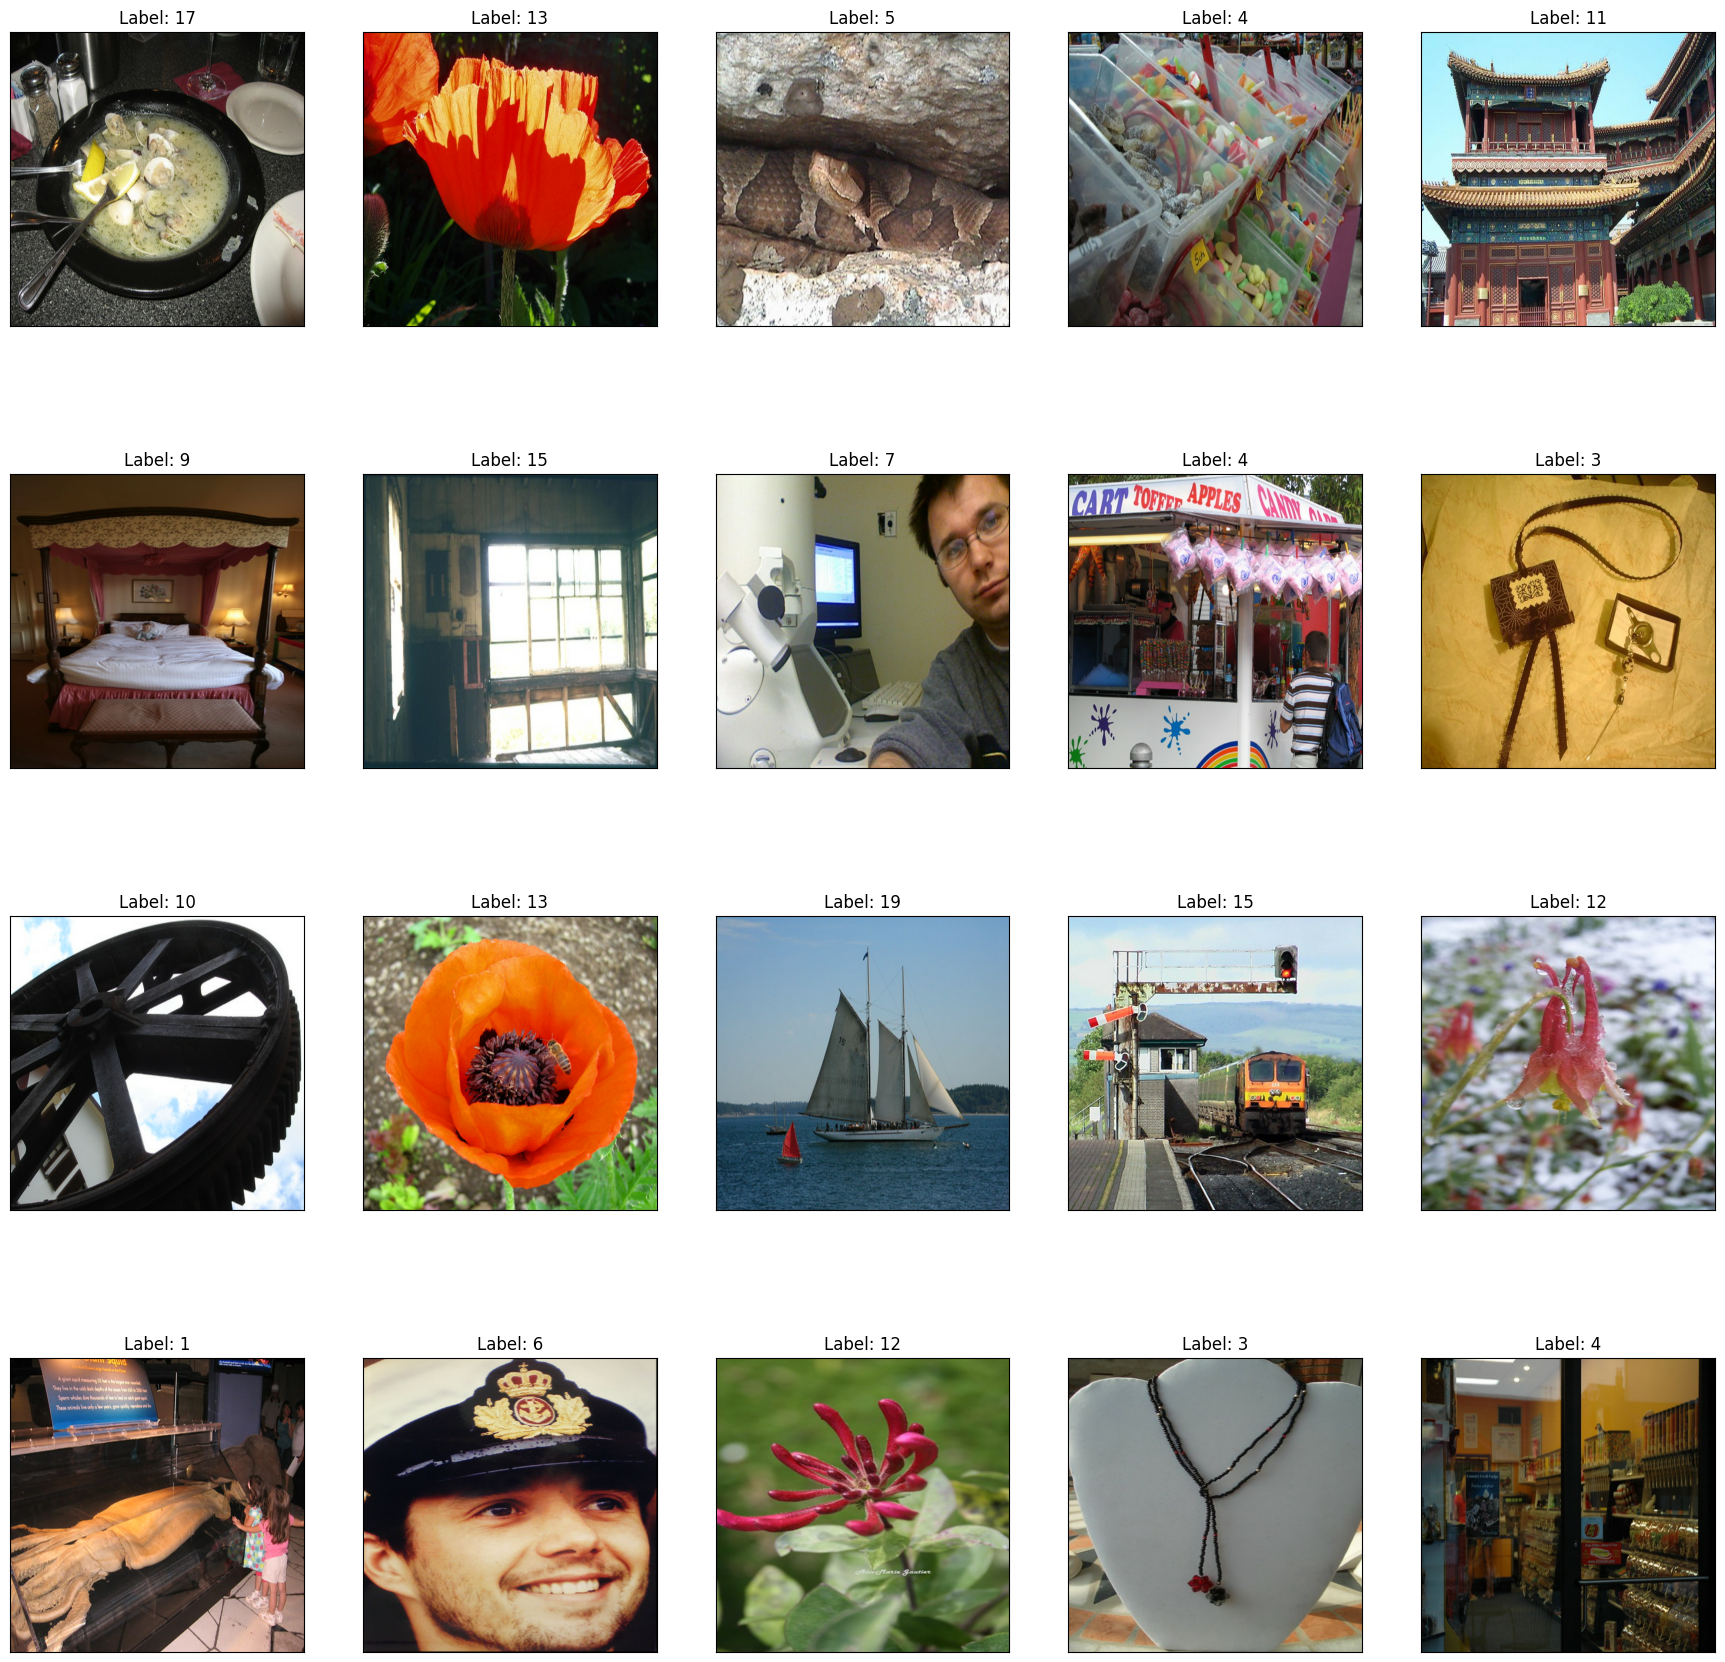

In [121]:
view_image(train_ds)

Basado en: https://albumentations.ai/docs/examples/tensorflow-example/

In [153]:
def aug_fn(image, img_size):

    data = {"image":image}

    aug_data = transform(**data)

    aug_img = aug_data["image"]

    #aug_img = tf.cast(aug_img/255.0,tf.uint8)
    aug_img = tf.image.convert_image_dtype(aug_img, tf.float32)
    return tf.image.resize(aug_img, size=[img_size, img_size])

In [154]:
def process_data(image, label, img_size):

    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)

    return aug_img, label

In [155]:
ds_alb = train_ds.map(partial(process_data, img_size=500), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

Se ve todo negro y no sé por qué

In [156]:
def view_image(ds):

    image, label = next(iter(ds)) # extract 1 batch from the dataset

    image = image.numpy()

    label = label.numpy()



    fig = plt.figure(figsize=(22, 22))

    for i in range(20):

        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])

        ax.imshow(np.array(image[i],np.int32))

        ax.set_title(f"Label: {label[i]}")

In [157]:
view_image(ds_alb)

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} error: OpenCV(4.10.0) /io/opencv/modules/core/src/matrix.cpp:1099: error: (-215:Assertion failed) dims <= 2 && step[0] > 0 in function 'locateROI'

Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_30/186667117.py", line 5, in aug_fn
    aug_data = transform(**data)

  File "/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py", line 348, in __call__
    data = t(**data)

  File "/opt/conda/lib/python3.10/site-packages/albumentations/core/transforms_interface.py", line 124, in __call__
    return self.apply_with_params(params, **kwargs)

  File "/opt/conda/lib/python3.10/site-packages/albumentations/core/transforms_interface.py", line 143, in apply_with_params
    result = target_function(np.require(arg, requirements=["C_CONTIGUOUS"]), **params)

  File "/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py", line 103, in apply
    return fblur.blur(img, kernel)

  File "/opt/conda/lib/python3.10/site-packages/albucore/decorators.py", line 43, in wrapped_function
    result = func(img, *args, **kwargs)

  File "/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/functional.py", line 21, in blur
    return blur_fn(img)

  File "/opt/conda/lib/python3.10/site-packages/albucore/utils.py", line 93, in __process_fn
    return process_fn(img, **kwargs)

cv2.error: OpenCV(4.10.0) /io/opencv/modules/core/src/matrix.cpp:1099: error: (-215:Assertion failed) dims <= 2 && step[0] > 0 in function 'locateROI'



	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 

y acá me tira este error

In [158]:
def set_shapes(img, label, img_shape=(500,500,3)):
    img.set_shape(img_shape)
    label.set_shape([0])
    return img, label

In [159]:
ds_alb_1 = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
ds_alb_1

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 500, 500, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 0), dtype=tf.int32, name=None))>

In [160]:
view_image(ds_alb_1)

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} error: OpenCV(4.10.0) /io/opencv/modules/core/src/matrix.cpp:1099: error: (-215:Assertion failed) dims <= 2 && step[0] > 0 in function 'locateROI'

Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_30/186667117.py", line 5, in aug_fn
    aug_data = transform(**data)

  File "/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py", line 348, in __call__
    data = t(**data)

  File "/opt/conda/lib/python3.10/site-packages/albumentations/core/transforms_interface.py", line 124, in __call__
    return self.apply_with_params(params, **kwargs)

  File "/opt/conda/lib/python3.10/site-packages/albumentations/core/transforms_interface.py", line 143, in apply_with_params
    result = target_function(np.require(arg, requirements=["C_CONTIGUOUS"]), **params)

  File "/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py", line 103, in apply
    return fblur.blur(img, kernel)

  File "/opt/conda/lib/python3.10/site-packages/albucore/decorators.py", line 43, in wrapped_function
    result = func(img, *args, **kwargs)

  File "/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/functional.py", line 21, in blur
    return blur_fn(img)

  File "/opt/conda/lib/python3.10/site-packages/albucore/utils.py", line 93, in __process_fn
    return process_fn(img, **kwargs)

cv2.error: OpenCV(4.10.0) /io/opencv/modules/core/src/matrix.cpp:1099: error: (-215:Assertion failed) dims <= 2 && step[0] > 0 in function 'locateROI'



	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 

## Modelo

In [10]:
data_dir = "/kaggle/working/imagenet_images"

train_dataset, val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode="categorical",
    image_size=(500, 500),
    batch_size=64,
    seed=42,
    validation_split=0.2,
    subset="both"
)

Found 2077 files belonging to 20 classes.
Using 1662 files for training.
Using 415 files for validation.


In [9]:

ds_tf = train_ds.map(partial(process_image, img_size=500), num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)


NameError: name 'train_ds' is not defined

In [11]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64, 128,256]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.0,0.1,0.5]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-3, 1e-4]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_LEARNING_RATE],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [12]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64, 128,256]))

HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.0,0.1,0.5]))

HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-3, 1e-4]))



METRIC_ACCURACY = 'accuracy'



with tf.summary.create_file_writer('logs/hparam_tuning').as_default():

    hp.hparams_config(

        hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_LEARNING_RATE],

        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],

    )

In [13]:
def train_model(hparams):

    with mlflow.start_run():

        base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(500, 500, 3))

        x = base_model.output

        x = GlobalAveragePooling2D()(x)

        x = Dense(hparams[HP_NUM_UNITS], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

        x = Dropout(hparams[HP_DROPOUT])(x)



        output_layer = Dense(20, activation='softmax')(x)

        model = Model(inputs=base_model.input, outputs=output_layer)



        for layer in base_model.layers:

            layer.trainable = False



        optimizer = Adam(learning_rate=hparams[HP_LEARNING_RATE])

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



        tensorboard_callback = TensorBoard(log_dir="logs", histogram_freq=1)

        hparams_callback = hp.KerasCallback("logs/hparam_tuning", hparams)



        # Train model

        history = model.fit(

            train_dataset,

            validation_data=val_dataset,

            epochs=2,

            callbacks=[tensorboard_callback, hparams_callback]

        )



        mlflow.log_param("num_units", hparams[HP_NUM_UNITS])

        mlflow.log_param("dropout", hparams[HP_DROPOUT])

        mlflow.log_param("learning_rate", hparams[HP_LEARNING_RATE])

        mlflow.log_metric("accuracy", max(history.history['accuracy']))



        mlflow.keras.log_model(model, "model")

In [14]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:

    for dropout in HP_DROPOUT.domain.values:

        for learning_rate in HP_LEARNING_RATE.domain.values:

            hparams = {

                HP_NUM_UNITS: num_units,

                HP_DROPOUT: dropout,

                HP_LEARNING_RATE: learning_rate,

            }

            print(f"--- Starting trial: {session_num+1}")

            print({h.name: hparams[h] for h in hparams})

            train_model(hparams)

            session_num += 1


--- Starting trial: 1
{'num_units': 64, 'dropout': 0.0, 'learning_rate': 0.0001}
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/2


I0000 00:00:1730654078.726821     122 service.cc:145] XLA service 0x7d2a50003c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730654078.726876     122 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730654078.726881     122 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730654102.861754     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.0877 - loss: 4.3416 - val_accuracy: 0.2048 - val_loss: 3.9738
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2678 - loss: 3.8020 - val_accuracy: 0.3639 - val_loss: 3.5511


2024/11/03 17:16:33 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/03 17:16:51 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpqouv5sv4/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 17:16:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Starting trial: 2
{'num_units': 64, 'dropout': 0.0, 'learning_rate': 0.001}
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3592 - loss: 3.5269 - val_accuracy: 0.7952 - val_loss: 1.7732
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8637 - loss: 1.4994 - val_accuracy: 0.8964 - val_loss: 1.2687


2024/11/03 17:18:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/03 17:18:15 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpu23eosig/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 17:18:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Starting trial: 3
{'num_units': 64, 'dropout': 0.1, 'learning_rate': 0.0001}
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.0868 - loss: 4.2962 - val_accuracy: 0.2530 - val_loss: 3.9059
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2644 - loss: 3.8036 - val_accuracy: 0.3952 - val_loss: 3.4767


2024/11/03 17:19:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/03 17:19:42 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp_sv1hyc3/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 17:19:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Starting trial: 4
{'num_units': 64, 'dropout': 0.1, 'learning_rate': 0.001}
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.2908 - loss: 3.6429 - val_accuracy: 0.8169 - val_loss: 1.8125
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8182 - loss: 1.6529 - val_accuracy: 0.8771 - val_loss: 1.2946


2024/11/03 17:20:56 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/03 17:21:09 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpx287n50i/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 17:21:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Starting trial: 5
{'num_units': 64, 'dropout': 0.5, 'learning_rate': 0.0001}
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.0346 - loss: 4.7459 - val_accuracy: 0.1446 - val_loss: 4.0611
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1155 - loss: 4.0625 - val_accuracy: 0.2916 - val_loss: 3.7920


2024/11/03 17:22:27 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/03 17:22:40 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpo8uvz778/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 17:22:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Starting trial: 6
{'num_units': 64, 'dropout': 0.5, 'learning_rate': 0.001}
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.1225 - loss: 4.1051 - val_accuracy: 0.5446 - val_loss: 2.8536
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4049 - loss: 2.8111 - val_accuracy: 0.8120 - val_loss: 1.8983


2024/11/03 17:23:54 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/03 17:24:07 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpntnbhzaa/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 17:24:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Starting trial: 7
{'num_units': 128, 'dropout': 0.0, 'learning_rate': 0.0001}
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.1237 - loss: 5.4166 - val_accuracy: 0.3880 - val_loss: 4.7198
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5352 - loss: 4.4914 - val_accuracy: 0.6699 - val_loss: 4.0238


2024/11/03 17:25:20 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/03 17:25:32 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp1h4mhnu6/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 17:25:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Starting trial: 8
{'num_units': 128, 'dropout': 0.0, 'learning_rate': 0.001}
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4046 - loss: 4.4060 - val_accuracy: 0.8530 - val_loss: 2.3259
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8987 - loss: 2.0537 - val_accuracy: 0.8771 - val_loss: 1.7251


2024/11/03 17:26:43 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/03 17:26:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpn_0kftxp/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 17:26:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Starting trial: 9
{'num_units': 128, 'dropout': 0.1, 'learning_rate': 0.0001}
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.1087 - loss: 5.4837 - val_accuracy: 0.3687 - val_loss: 4.7240
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4238 - loss: 4.5233 - val_accuracy: 0.6337 - val_loss: 4.0087


2024/11/03 17:28:12 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/03 17:28:24 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpwm9xrqa0/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 17:28:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Starting trial: 10
{'num_units': 128, 'dropout': 0.1, 'learning_rate': 0.001}
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3979 - loss: 4.4080 - val_accuracy: 0.8675 - val_loss: 2.3319
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8776 - loss: 2.1083 - val_accuracy: 0.8819 - val_loss: 1.7097


2024/11/03 17:29:38 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/03 17:29:51 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpvdbpxd76/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 17:29:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Starting trial: 11
{'num_units': 128, 'dropout': 0.5, 'learning_rate': 0.0001}
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.0712 - loss: 5.6471 - val_accuracy: 0.2771 - val_loss: 4.9148
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2010 - loss: 4.9501 - val_accuracy: 0.5446 - val_loss: 4.4395


2024/11/03 17:31:05 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/03 17:31:18 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpxh1ixt9h/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 17:31:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Starting trial: 12
{'num_units': 128, 'dropout': 0.5, 'learning_rate': 0.001}
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.2186 - loss: 5.0073 - val_accuracy: 0.7783 - val_loss: 2.8284
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6745 - loss: 2.8501 - val_accuracy: 0.8699 - val_loss: 1.9903


2024/11/03 17:32:33 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/03 17:32:45 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp4xvt8vam/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 17:32:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Starting trial: 13
{'num_units': 256, 'dropout': 0.0, 'learning_rate': 0.0001}
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.1612 - loss: 7.3458 - val_accuracy: 0.5687 - val_loss: 6.3802
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6938 - loss: 6.0425 - val_accuracy: 0.7831 - val_loss: 5.4541


2024/11/03 17:33:58 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/03 17:34:11 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp4mu5_26e/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 17:34:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Starting trial: 14
{'num_units': 256, 'dropout': 0.0, 'learning_rate': 0.001}
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4779 - loss: 6.0855 - val_accuracy: 0.8554 - val_loss: 3.6518
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9196 - loss: 3.1729 - val_accuracy: 0.8916 - val_loss: 2.4917


2024/11/03 17:35:22 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/03 17:35:35 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpxg49s2r8/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 17:35:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Starting trial: 15
{'num_units': 256, 'dropout': 0.1, 'learning_rate': 0.0001}
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.1845 - loss: 7.4211 - val_accuracy: 0.5398 - val_loss: 6.3591
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5886 - loss: 6.0872 - val_accuracy: 0.7880 - val_loss: 5.4409


2024/11/03 17:36:52 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/03 17:37:05 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp2vg6rge2/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 17:37:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Starting trial: 16
{'num_units': 256, 'dropout': 0.1, 'learning_rate': 0.001}
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4358 - loss: 6.1934 - val_accuracy: 0.8747 - val_loss: 3.5195
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8979 - loss: 3.1433 - val_accuracy: 0.8867 - val_loss: 2.4191


2024/11/03 17:38:19 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/03 17:38:32 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmplq16m2k_/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 17:38:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Starting trial: 17
{'num_units': 256, 'dropout': 0.5, 'learning_rate': 0.0001}
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.0887 - loss: 7.7786 - val_accuracy: 0.4434 - val_loss: 6.7142
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3127 - loss: 6.7034 - val_accuracy: 0.6578 - val_loss: 5.9852


2024/11/03 17:40:00 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/03 17:40:13 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmph4pctyj2/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 17:40:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Starting trial: 18
{'num_units': 256, 'dropout': 0.5, 'learning_rate': 0.001}
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.3530 - loss: 6.5104

KeyboardInterrupt: 

In [15]:
%load_ext tensorboard
%tensorboard --logdir /content/logs

## Grid Search